In [27]:
from alphaswarm.services.alchemy import AlchemyClient
from alphaswarm.tools.alchemy.alchemy_price_history import GetAlchemyPriceHistoryBySymbol
from alphaswarm.tools.forecasting.price_forecasting import ForecastTokenPrice
from alphaswarm.services.alchemy import HistoricalPriceBySymbol

from alphaswarm.tools.forecasting.price_forecasting import PriceForecastResponse
from autogluon.timeseries import TimeSeriesDataFrame


import pandas as pd

In [30]:

total_days = 130
num_y = 30
symbol = "WETH"

alchemy_client = AlchemyClient.from_env()
tool = GetAlchemyPriceHistoryBySymbol(alchemy_client)
gold_result = tool.forward(symbol=symbol, interval="1d", history=total_days)

# use the first 6 days data as input to the forecaster
historical_data = HistoricalPriceBySymbol(symbol=gold_result.symbol, data=[p for p in gold_result.data[:-num_y]])

## Predictions without context

In [4]:
forecaster = ForecastTokenPrice()
forecast_data = forecaster.forward(historical_price_data = historical_data,
                              forecast_horizon=f"everyday for next {num_y} days",
                              supporting_context=None
                              )

In [81]:
def transform_forecast_to_dataframe(symbol: str, price_data: PriceForecastResponse) -> pd.DataFrame:

    # Create empty lists to store the data
    item_ids = []
    timestamps = []
    target_values = []
    
    # Iterate through each PriceForecast in the data list
    for price_point in price_data.forecast:
        item_ids.append(symbol)
        # Format the timestamp to include date with a consistent time of 01:00:00
        date_with_time = f"{price_point.timestamp.strftime('%Y-%m-%d %H:%M:%S')}"
        timestamps.append(date_with_time)
        target_values.append(float(price_point.price))  # Convert Decimal to float
    
    # Create the DataFrame
    df = pd.DataFrame({
        'item_id': item_ids,
        'timestamp': pd.to_datetime(timestamps),  # Convert strings to naive datetime
        'target': target_values
    })
    
    return df


def transform_historical_price_to_dataframe(price_data: HistoricalPriceBySymbol) -> pd.DataFrame:

    # Create empty lists to store the data
    item_ids = []
    timestamps = []
    target_values = []
    
    # Extract data from the HistoricalPriceBySymbol object
    symbol = price_data.symbol
    
    # Iterate through each HistoricalPrice in the data list
    for price_point in price_data.data:
        item_ids.append(symbol)
        # Format the timestamp to include date with a consistent time of 01:00:00
        date_with_time = f"{price_point.timestamp.strftime('%Y-%m-%d %H:%M:%S')}"
        timestamps.append(date_with_time)
        target_values.append(float(price_point.value))  # Convert Decimal to float
    
    # Create the DataFrame
    df = pd.DataFrame({
        'item_id': item_ids,
        'timestamp': pd.to_datetime(timestamps),  # Convert strings to naive datetime
        'target': target_values
    })
    
    return df

In [84]:
predictions = TimeSeriesDataFrame(transform_forecast_to_dataframe(symbol, forecast_data)).iloc[1:]
predictions = predictions.rename(columns={"target": "mean"})

In [137]:
train_data = TimeSeriesDataFrame(transform_historical_price_to_dataframe(historical_data))

In [85]:
test_df = transform_historical_price_to_dataframe(HistoricalPriceBySymbol(symbol=gold_result.symbol, data=[p for p in gold_result.data[-num_y:]]))
test_data = TimeSeriesDataFrame(test_df)

<Axes: xlabel='timestamp'>

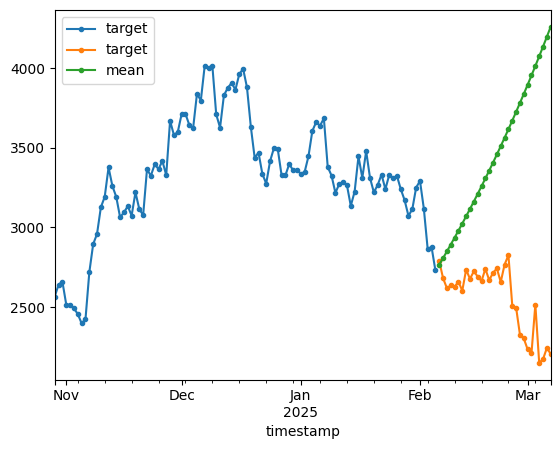

In [140]:
ax = train_data.reset_index().plot(x="timestamp", y="target", style='.-')
test_data.reset_index().plot(x="timestamp", y="target", style='.-', ax=ax)
predictions.reset_index().plot(x="timestamp", y="mean", style='.-', ax=ax)

In [86]:
from autogluon.timeseries.metrics import RMSE, MAPE, MASE

metric = MAPE()
# metric.save_past_metrics(train_data)
metric.compute_metric(test_data, predictions)

0.37814899634023996

## Use Context

In [71]:
print(historical_data.data[0].timestamp)
print(historical_data.data[-1].timestamp)

2024-10-29 00:00:00+00:00
2025-02-05 00:00:00+00:00


In [72]:
additional_context = """
Based on the search results, several key factors could influence the price of ETH/WETH between October 29, 2024, and February 5, 2025:

## Market Catalysts

The most important date for crypto markets was February 5, 2025, which marked a significant turning point[3]. Leading up to this date, several developments could impact Ethereum's price:

- **Ecosystem Growth**: This is identified as one of two major catalysts for Ethereum in late 2024 and early 2025[3]
- **Bitcoin Performance**: ETH price movement is partially tied to BTC reaching new all-time highs, which is considered the second major catalyst[3]
- **Institutional Adoption**: Accelerated institutional investment could significantly impact ETH prices during this period[3]

## Technical Developments

- **Pectra Upgrade**: The upcoming Ethereum upgrade was expected to serve as a potential short-term catalyst for price recovery[1]
- **Network Activity**: Declining DeFi metrics in early 2025 showed weakness, with total value locked (TVL) dropping significantly from January peaks[1]
- **Layer 2 Solutions**: Capital was flowing from Ethereum to alternative ecosystems such as layer 2 solutions and Solana during this period[1]

## Market Sentiment Factors

- **Quantitative Tightening (QT)**: The Federal Reserve's monetary policy was creating patterns similar to the 2019 market cycle, potentially affecting ETH price movement[1]
- **Exchange Balances**: ETH exchange balances dropped to a 9-year low, potentially creating scarcity if demand returned to the market[5]
- **Market Rotation**: Capital flow between Bitcoin and Ethereum was expected to eventually reverse, though timing remained uncertain[5]

## Regulatory Developments

- **White House Crypto Summit**: Scheduled for March 7, 2025, but anticipation of this event could influence market sentiment during the target period[1]
- **ETF Approval Expectations**: Potential approval of an Ethereum ETF was driving some expert predictions[3]

These factors collectively created a complex environment for Ethereum during the October 2024 to February 2025 period, with both bullish and bearish forces at play.
"""

In [105]:
forecast_data_w_context = forecaster.forward(historical_price_data = historical_data,
                              forecast_horizon=f"everyday for next {num_y} days",
                              supporting_context=additional_context
                              )

In [117]:
predictions_w_context = TimeSeriesDataFrame(transform_forecast_to_dataframe(symbol, forecast_data_w_context)).iloc[1:]
predictions_w_context = predictions_w_context.rename(columns={"target": "mean"})

In [88]:
metric.compute_metric(test_data, predictions_w_context)

0.035525855929158065

<Axes: xlabel='timestamp'>

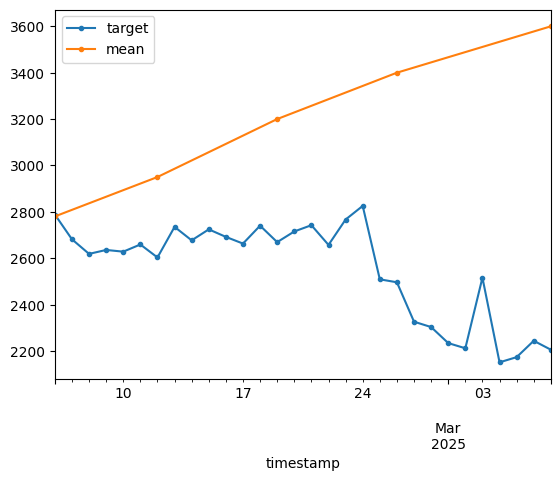

In [132]:
ax = test_data.reset_index().plot(x="timestamp", y="target", style='.-')
predictions_w_context.reset_index().plot(x="timestamp", y="mean", style='.-', ax=ax)